In [292]:
import os
from pathlib import Path
import json
import joblib
import scipy.io as sio

import numpy as np
import xarray as xr
import pandas as pd
import h5py

import brainscore

from brainio_collection.lookup import sha1_hash
from brainio_base.stimuli import StimulusSet
from brainio_base.assemblies import NeuronRecordingAssembly
from brainio_collection.packaging import package_data_assembly, package_stimulus_set
from brainio_contrib.dicarlo.sanghavi import filter_neuroids

import matplotlib.pyplot as plt
import seaborn as sns


import configparser
config = configparser.ConfigParser(interpolation=configparser.ExtendedInterpolation())
config.read('../spike_tools/spike_config.ini');


In [299]:
config['Experiment Information']['name'] = 'stimulation-cIT'


date = '211115'
cond_num = 0


In [300]:
dataPath = "/braintree/data2/active/users/ssazaidi/projects/"+config['Experiment Information']['name']+"/monkeys/oleo/"

procDataPath = dataPath+'intanproc'

In [301]:
### Load MWORKS DATA ###

mworksDirproc = '../../projects/'+config['Experiment Information']['name']+'/monkeys/oleo/mworksproc/'
mworksFilename = [i for i in os.listdir(mworksDirproc) if date in i][0]
data_info = pd.read_csv(os.path.join(mworksDirproc, mworksFilename))
samp_on_id = data_info.stim_id.values
samp_on_current = data_info.stim_current.values
stimulus_presented = data_info.stimulus_presented

In [302]:
os.listdir(mworksDirproc)

['datamaco-stimulation-cIT-20211115-125506_mwk.csv',
 'datamaco-stim_corners-20211116-125325_mwk.csv']

In [303]:
im_nums = np.unique(data_info['stimulus_presented'])

for i, im_num in enumerate(im_nums):
    if im_num not in stimulus_presented:
        print('Hello')

In [304]:
im_nums

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72])

## PSTH Analysis

In [305]:
directory_path = os.path.join(procDataPath,[i for i in os.listdir(procDataPath) if date in i][0])

filenames = [os.path.join(directory_path, i) for i in os.listdir(directory_path) if date in i]

analysis_conditions = ['','salpa', 'wosalpa', 'woartefacts', 'thres4', 
                               'bin5', 'bin2', 'salpabin5', 'salpabin2', 
                               'absthres40', 'absthres40bin5', 'absthres40bin2', 'absthres30']

timebin_sizes = {'':10,'salpa':10, 'wosalpa':10, 'woartefacts':10, 'thres4':10, 'bin5':5, 
                         'bin2':2, 'salpabin5':5, 'salpabin2':2,  
                         'absthres40':10, 'absthres40bin5':5, 'absthres40bin2':2, 'absthres30':10}


analysis_condition = '_'+analysis_conditions[cond_num] if analysis_conditions[cond_num] else analysis_conditions[cond_num] 
timebin_size = timebin_sizes[analysis_conditions[cond_num]]
filename = [i for i in filenames if 'psth'+analysis_condition+'.mat' in i][0]
print(filename)

/braintree/data2/active/users/ssazaidi/projects/stimulation-cIT/monkeys/oleo/intanproc/oleo_stimulation-cIT_211115_125805/oleo_stimulation-cIT_211115_125805_psth.mat


In [306]:
filename = '/braintree/data2/active/users/ssazaidi/projects/stimulation-cIT/monkeys/oleo/intanproc/oleo_stimulation-cIT_211115_125805/psth/amp-A-000_psth.mat'

In [307]:
data = sio.loadmat(filename)

psth = np.asarray(data['psth'])
meta = data['meta']

In [308]:
i = 2
meta_ids[i-1],stim_num_to_id[str(i)]

('a-010', 'a-010')

In [255]:
rate.shape

(72, 61, 30, 192)

In [148]:
timebase = np.arange(meta['start_time_ms'], meta['stop_time_ms'], meta['tb_ms'])
t_cols = np.where((timebase >= -100) & (timebase < 200))[0]
# rate = np.mean(psth[:, :, t_cols, :], axis=2)
rate = psth[:, :, t_cols, :]

In [149]:
data_assembly = xr.DataArray(rate,
                                           coords={'repetition': ('repetition', list(range(rate.shape[1]))),
                                                   'image_id': ('image', list(range(rate.shape[0]))),
                                                   'id': ('image', list(range(rate.shape[0]))),
                                                    'time_id': ('time', list(range(rate.shape[2]))) },
                                           dims=['image', 'repetition', 'time', 'neuroid'])


In [150]:
neuroid_meta = pd.DataFrame(json.load(open('/braintree/data2/active/users/ssazaidi/' + 'array-metadata' + '/oleo_mapping.json')))

In [151]:
import copy
mod_neuroid_meta = copy.copy(neuroid_meta)

In [152]:
# mod_neuroid_meta.iloc[192:,-1] = mod_neuroid_meta.iloc[192:,-1] 
# mod_neuroid_meta.iloc[192:,2]  = mod_neuroid_meta.iloc[192:,2] 

# mod_neuroid_meta.drop([str(i) for i in np.arange(96,192)], axis='index')

In [153]:
for column_name, column_data in neuroid_meta.iteritems():
        data_assembly = data_assembly.assign_coords(**{f'{column_name}': ('neuroid', list(column_data.values[:psth.shape[-1]]))})
data_assembly = data_assembly.stack(presentation=('image', 'repetition')).reset_index('presentation')
data_assembly = data_assembly.drop('image')
data_assembly = data_assembly.transpose('presentation', 'neuroid', 'time')
data_assembly = NeuronRecordingAssembly(data_assembly)    

## add current and IDs

In [154]:
data_info = pd.read_csv(os.path.join(mworksDirproc, mworksFilename))
samp_on_id = data_info.stim_id.values
samp_on_current = data_info.stim_current.values
stimulus_presented = data_info.stimulus_presented.values

In [155]:
temp = np.unique(list(zip(stimulus_presented,samp_on_id,samp_on_current)), axis=0)
stim_num_to_current = dict(zip(temp[:,0],temp[:,2]))
stim_num_to_id = dict(zip(temp[:,0],temp[:,1]))

In [273]:
meta_currents = [np.unique(i[0])[0] for i in meta['stim_currents'][0][0][0]]
meta_ids = [np.unique(i[0])[0] for i in meta['stim_ids'][0][0][0]]

In [291]:
data_assembly = data_assembly.assign_coords(samp_on_current=('presentation',[meta_currents[i] for i in data_assembly.image_id.values]))
data_assembly = data_assembly.assign_coords(samp_on_id=('presentation',[meta_ids[i] for i in data_assembly.image_id.values]))

## Select based on Normalizers

In [157]:
filtered_normalizer_assemblies = joblib.load('filtered_assembly_by_date.pkl')

In [158]:
filtered_assembly = filtered_normalizer_assemblies[date]

KeyError: '211115'

## Remove NaNs

In [161]:
data_assembly = data_assembly[np.setdiff1d(np.arange(len(data_assembly)), np.unique(np.where(np.sum(np.isnan(data_assembly), axis = 2))[0]))]
data_assembly = data_assembly[np.where(data_assembly.samp_on_current != '0')[0]]

In [162]:
data_assembly = data_assembly.sel(neuroid=np.isin(data_assembly.neuroid_id, filtered_assembly.neuroid_id))

NameError: name 'filtered_assembly' is not defined

In [163]:
# data_assembly

In [164]:
ceiling_obj = brainscore.metrics.ceiling.InternalConsistency()
data_consistency = []

for t in range(data_assembly.shape[-1]):
    data_consistency.append(ceiling_obj(data_assembly[...,t]))


cross-validation: 100%|██████████| 10/10 [00:03<00:00,  2.50it/s]
/om/user/ssazaidi/miniconda3/envs/dicarlo_lab/lib/python3.7/site-packages/xarray/core/alignment.py:307: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  index = joiner(matching_indexes)
cross-validation: 100%|██████████| 10/10 [00:03<00:00,  2.56it/s]
/om/user/ssazaidi/miniconda3/envs/dicarlo_lab/lib/python3.7/site-packages/xarray/core/alignment.py:307: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  index = joiner(matching_indexes)
cross-validation: 100%|██████████| 10/10 [00:03<00:00,  2.58it/s]
/om/user/ssazaidi/miniconda3/envs/dicarlo_lab/lib/python3.7/site-packages/xarray/core/alignment.py:307: FutureWarning: Index.__or__ operating as a set operation is deprecated

In [165]:
data_mean_consistency = np.array([i[0] for i in data_consistency])

In [166]:
ait_raw = data_consistency[0].raw[:,data_assembly.subregion == 'aIT'].data
cit_raw = data_consistency[0].raw[:,data_assembly.subregion == 'cIT'].data

print(cit_raw.shape)

(10, 96)


In [167]:
ait_mean_consistency = np.array([i.raw[:,data_assembly.subregion == 'aIT'].data.mean(0) for i in data_consistency]).T
cit_mean_consistency = np.array([i.raw[:,data_assembly.subregion == 'cIT'].data.mean(0) for i in data_consistency]).T

No handles with labels found to put in legend.


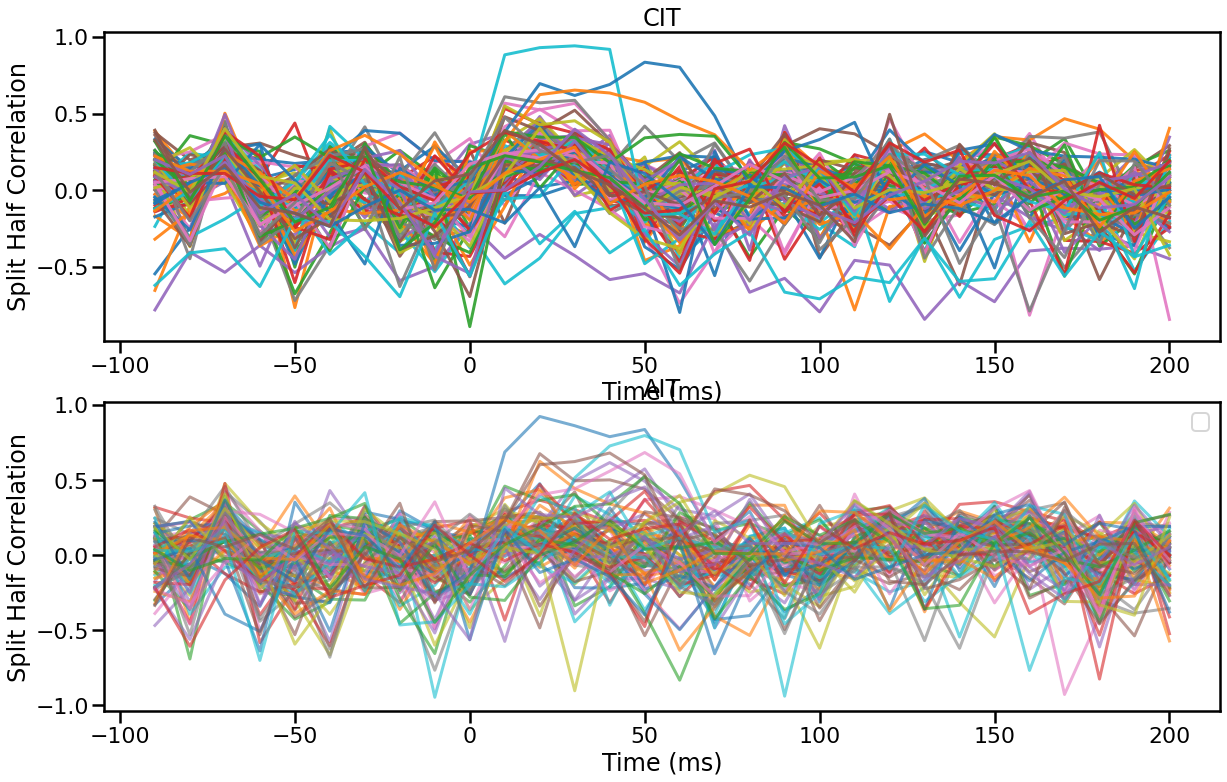

In [173]:
sns.set_context('poster')

f = plt.figure(figsize=(20,12.5))
plt.subplot(2,1,1)
plt.plot((np.arange(30)+1)*10 - 100, cit_mean_consistency.T, alpha=0.9)
# plt.fill_between(np.arange(30)*10 - 100, 
#                 ait_mean_consistency.min(0),
#                 ait_mean_consistency.max(0),
#                 alpha=0.5)
plt.title('CIT')
plt.xlabel('Time (ms)')
plt.ylabel('Split Half Correlation')
plt.subplot(2,1,2)
plt.plot((np.arange(30)+1)*10 - 100, ait_mean_consistency.T, alpha=0.6)
# plt.fill_between(np.arange(30)*10 - 100, 
#                 cit_mean_consistency.min(0),
#                 cit_mean_consistency.max(0),
#                 alpha=0.5)


plt.title('AIT')
plt.xlabel('Time (ms)')
plt.ylabel('Split Half Correlation')
plt.legend()
plt.savefig('Internal_consistency_brainscore_'+date+'.jpg', bbox_inches='tight')

In [169]:
aIT_assembly = data_assembly[:,data_assembly.subregion == 'aIT',:]
cIT_assembly = data_assembly[:,data_assembly.subregion == 'cIT',:]


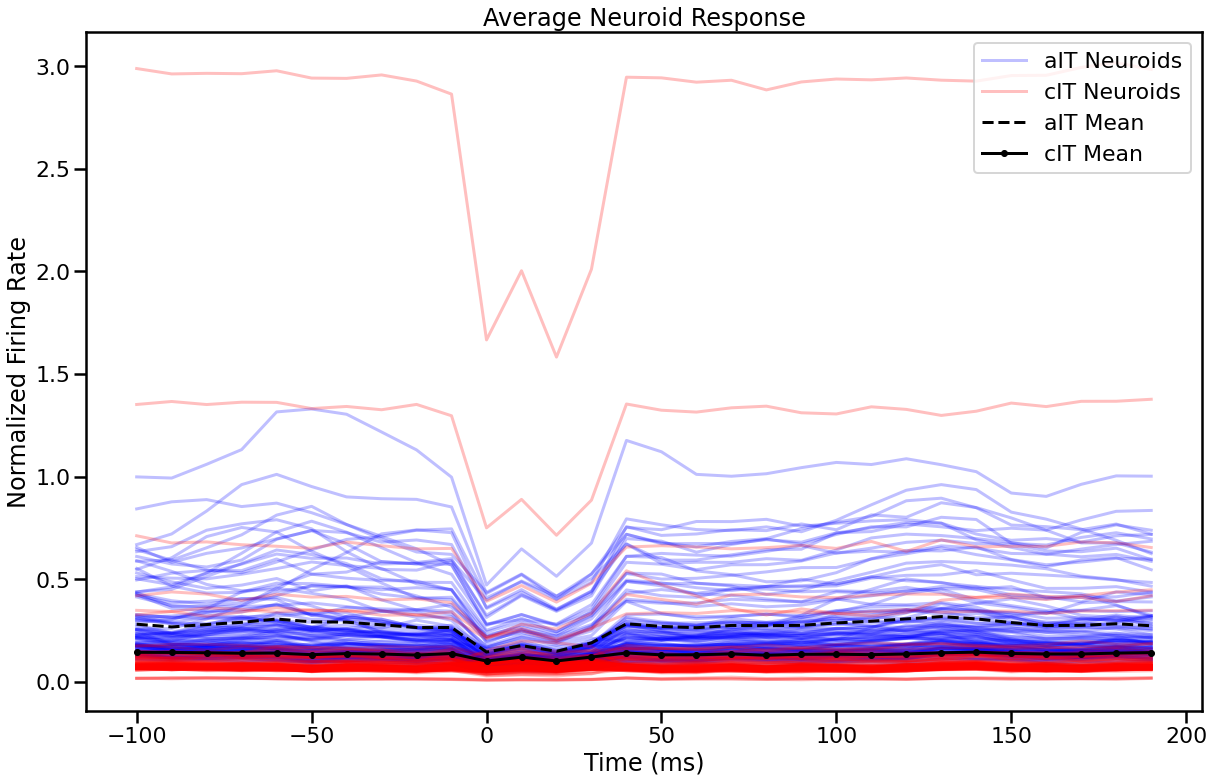

In [170]:
ait_average = np.mean(aIT_assembly, axis=0)
cit_average = np.mean(cIT_assembly, axis=0)

sns.set_context('poster')

f = plt.figure(figsize=(20,12.5))
plt.plot(np.arange(30)*10 - 100, ait_average.T,'b' , label='aIT Neuroids', alpha=0.25)



plt.plot(np.arange(30)*10 - 100, cit_average.T, 'r' , label='cIT Neuroids', alpha=0.25)

plt.plot(np.arange(30)*10 - 100, ait_average.T.mean(axis=1), 'k--' , label='aIT Mean')
plt.plot(np.arange(30)*10 - 100, cit_average.T.mean(axis=1), 'k.-' , label='cIT Mean')

handles, labels = plt.gca().get_legend_handles_labels()
newLabels, newHandles = [], []

for handle, label in zip(handles, labels):
    if label not in newLabels:
        newLabels.append(label)
        newHandles.append(handle)

plt.legend(newHandles, newLabels, loc = 'upper right')

# plt.xlim([np.min(np.arange(30)*10 - 100), np.max(np.arange(30)*10 - 100)])

plt.xlabel('Time (ms)')
plt.ylabel('Normalized Firing Rate')
plt.title('Average Neuroid Response')

plt.savefig('Average_Neuroid_Response'+date+'.png', bbox_inches='tight')

In [171]:
## DO NOT DELETE - USED IN MWK_ULTRA.PY ##
# temp = np.unique(list(zip(stimulus_presented,samp_on_id,samp_on_current)), axis=0)
# stim_num_key = dict(zip([tuple( i )for i in temp], np.arange(1,len(temp)+1)))
# new_stim_presented = [stim_num_key[tuple(i)] for i in np.array(list(zip(stimulus_presented,samp_on_id,samp_on_current)))]

In [172]:
unique_combs, unique_counts = np.unique(np.array(list(zip(samp_on_id,samp_on_current))), axis=0, return_counts=True)

In [187]:
np.max(unique_counts), unique_combs[np.argmax(unique_counts)]

(206, array(['d-008', '0'], dtype='<U21'))

In [275]:
[stim_num_to_id[str(i+1)] for i in data_assembly.image_id.values]

6720

In [284]:
test_assembly = data_assembly.copy()

In [86]:
len(np.where(data_assembly.samp_on_current == '0')[0])

721